# API TDD (Test-Driven Development)

The purpose of this notebook is to work out how a user may want to use the library. Code will be written using the desired API/syntax, and then the library will be adjusted. Functions that are not of interest to a typical user will be rendered private (\_privatename single underscore convention).

In [1]:
import os
import sys
import numpy as np
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300
%matplotlib inline

In [2]:
%config InlineBackend.figure_format = 'svg'  # makes inline plot look less blurry

In [3]:
home_path = os.path.abspath(os.path.join('..'))
if home_path not in sys.path:
    sys.path.append(home_path)

In [4]:
tests_path = os.path.abspath(os.path.join('..', 'tests'))
if tests_path not in sys.path:
    sys.path.append(tests_path)

## Definitions

* multiplet
* spin system
* spectrum
* peak
* peaklist
* lineshape



## Scenario: user wants to plot a spectrum for an ABX 3-spin system.


Setup: user has v (frequency) and J (coupling constant) data as python lists (or numpy arrays). For this example, a function from nmrtool's test suite will provide some example data:

In [5]:
# load the parameters used by Rioux for his example at:
# http://www.users.csbsju.edu/~frioux/nmr/ABC-NMR-Tensor.pdf
from simulation_data import rioux

In [50]:
v, J = rioux()
print(v)  # frequencies in Hz
print(J)  # matrix of coupling constants

[430. 265. 300.]
[[ 0.   7.  15. ]
 [ 7.   0.   1.5]
 [15.   1.5  0. ]]


The J matrix is constructed so that J[a, b] is the coupling constant between v[a] and v[b]. The diagonal elements should be 0.

In [7]:
from nmrtools import qm

In [51]:
spectrum = qm.spectrum(v, J, normalize=True)
spectrum
# TODO: refactor "spectrum" to "peaklist"

[(260.66152857482973, 0.2301124913178783),
 (291.3191136690316, 0.22882003310401844),
 (419.5193577561387, 0.29107244545559474),
 (292.84688854093866, 0.21381231157251776),
 (426.4877446901903, 0.26629867696733883),
 (262.18930344673686, 0.2487606172641341),
 (434.52319595017997, 0.2300458619680737),
 (267.62991550888137, 0.24855578963215696),
 (306.32295186307283, 0.29251680284079623),
 (441.4915828842316, 0.21257278181929298),
 (307.85072673497996, 0.26486802047130636),
 (269.1576903807885, 0.2725641675868917)]

When normalize=True, the total intensities should add up to the total number of nuclei in the spin system.

The nmrtools.plt library has functions for convenient plotting of common nmrtools data types (peaklist; lineshape).

In [9]:
from nmrtools.plt import mplplot

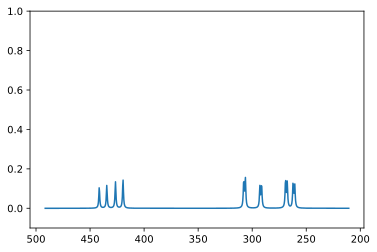

In [10]:
mplplot(spectrum);

In [11]:
from nmrtools.plt import mplplot_stick

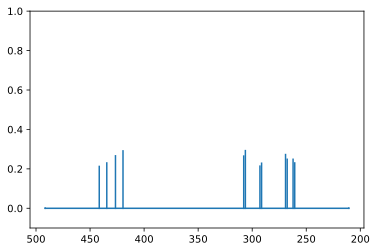

In [12]:
mplplot_stick(spectrum);

__How does a user want their spectrum?__ Currently a list of tuples is provided. Some routines may be better implemented if the spectrum remained a numpy array. e.g. compile_spectrum provides a 2D array of `[[frequency, intensity]...]`. normalize_spectrum then separates into frequency and intensity arrays, processes the latter, then puts them back together.

Need to survey how the most common plotting libraries handle x, y data. Two scenarios: lineshape, and stick.

Note that a spectrum with [(v, I)...] format can be easily converted to [v...], [I...]:
`v, I = zip(*spectrum)`


__What is a multiplet, and what can you do with it?__ It has v, I, and J information. If multiplied, the intensity increases. If added, you get a spectrum. < and > may not make sense (but could be v order; probably not I order). Challenge: representation? Can you get it to determine dt, td etc?

In [15]:
from nmrtools.firstorder import Multiplet

In [16]:
# 1200 Hz, 2H, td, J= 7.1, 1.1 Hz
td = Multiplet(1200.0, 2, [(7.1, 2), (1.1, 1)])

In [17]:
from nmrtools.plt import mplplot_stick

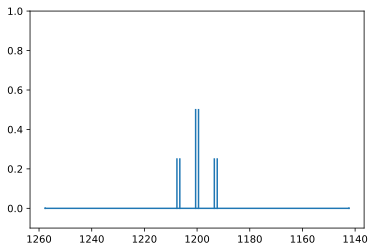

In [18]:
mplplot_stick(td.peaklist);

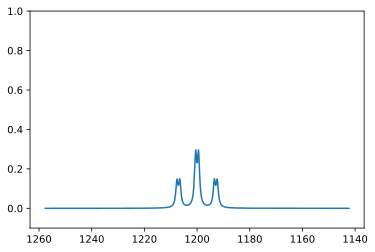

In [19]:
mplplot(td.peaklist);

## Scenario: User wants to model a specific spin system using an explicit (non-qm) solution

--> nmrtools.partial

In [20]:
import timeit

## Scenario: User wants to model DNMR two-spin exchange, without and with coupling

The nmrtools.dnmr library provides functions for calculating DNMR lineshapes, and classes to describe these systems. Currently models for two uncoupled nuclei and two coupled nuclei are provided.

In [21]:
from nmrtools.dnmr import DnmrTwoSinglets, DnmrAB

For: v<sub>a</sub> = 165 Hz, v<sub>b</sub> = 135 Hz, k = 65.9 {todo: units}, line widths (at the slow exchange limit) w<sub>a</sub> and w<sub>b</sub> = 0.5 Hz, and population of state a = 0.5 (i.e. 50%):

In [73]:
two_singlet_system = DnmrTwoSinglets(165.00, 135.00, 65.9, 0.50, 0.50, 0.50)

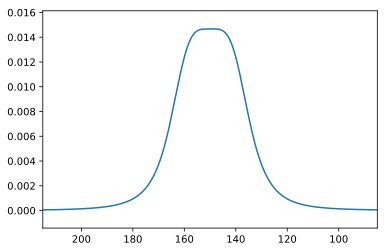

In [74]:
mpl_lineshape(*two_singlet_system.spectrum());  # TODO: rename to lineshape?

When using the provided classes, individual parameters can be changed. In the previous case, k = 65.9 corresponds to the point of coalescence. When the rate of exchange is lower, two separate peaks are observed.

In [75]:
two_singlet_system.k = 5

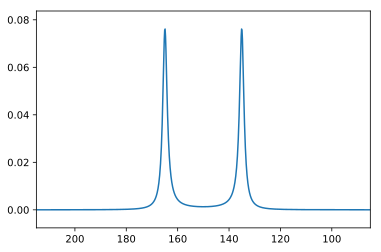

In [76]:
mpl_lineshape(*two_singlet_system.spectrum());

What if the relative populations of states a and b are 75% and 25%, respectively?

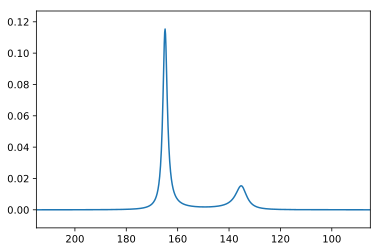

In [78]:
two_singlet_system.pa = 0.75
mpl_lineshape(*two_singlet_system.spectrum());

Now, model an AB-like system of two coupled nuclei undergoing exchange. Here, the frequencies are the same as for the previous system. J = 5 Hz, k = 12 {units}, and the line width (at the slow exchange limit) is 0.5 Hz.

In [36]:
from nmrtools.dnmr import DnmrAB

In [86]:
AB = DnmrAB(165, 135, 5, 10, 0.5)

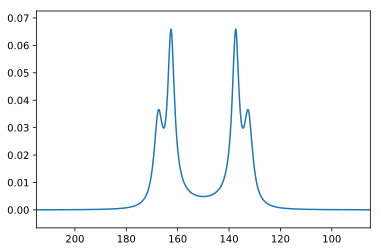

In [87]:
mpl_lineshape(*AB.spectrum());